In [1]:
import matplotlib 
from matplotlib import pyplot as plt

In [2]:
# Load MNIST data

import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array of bytes:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)


# 60000 images, each 784 elements (28 * 28 pixels)
X_train = load_images("../data/mnist/train-images-idx3-ubyte.gz")

# 10000 images, each 784 elements, with the same structure as X_train
X_test = load_images("../data/mnist/t10k-images-idx3-ubyte.gz")


def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y


# !!! EDIT PATHS TO WHERE YOUR MNIST DATA IS !!!

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("../data/mnist/train-labels-idx1-ubyte.gz")

# 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# 10000 labels, each a single digit from 0 to 9
Y_test = load_labels("../data/mnist/t10k-labels-idx1-ubyte.gz")

In [39]:
# A neural network implementation (almost the same as backpropagation.py,
# except for a tiny refactoring in the back() function).

import numpy as np


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)


def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))


def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]


def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)


def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)


def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T)
                            * sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)


def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def report(iteration, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    print("Iteration: %5d, Loss: %.8f, Accuracy: %.2f%%" %
          (iteration, training_loss, accuracy))
    return accuracy

def report_JR(iteration, X_train, Y_train, X_test, Y_test, w):
    matches = np.count_nonzero(classify(X_test, w) == Y_test)
    n_test_ex = Y_test.shape[0]
    matches = matches * 100.0 / n_test_ex
    training_loss = loss(X_train, Y_train, w)
    print('iteration {} - loss: {:.2f}, matches: {:.2f}%'.format(iteration, training_loss, matches))
    return matches

    

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, iterations, lr):
    success_rates = []
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]
    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    for iteration in range(iterations):
        y_hat, h = forward(X_train, w1, w2)
        w1_gradient, w2_gradient = back(X_train, Y_train, y_hat, w2, h)
        w1 = w1 - (w1_gradient * lr)
        w2 = w2 - (w2_gradient * lr)
        accuracy = report(iteration, X_train, Y_train, X_test, Y_test, w1, w2)
        success_rates.append(accuracy)
    return (w1, w2, success_rates)


In [5]:
# create a dictionary to store your success rates
# !!! UNCOMMENT, EXECUTE, AND COMMENT THE LINE BELOW AGAIN !!!
# !!! DON'T EXECUTE THE LINE AGAIN AFTER STARTING TO COLLECT RESULTS !!!

#success_rates = {}

In [41]:
n_train = 6000 # number of examples in training data (max is 60,000)
n_test  = 1000 # number of examples in training data (max is 10,000)
n_nodes = 400 # number of hidden nodes
n_iters = 2000 # number of iterations
lr      = 0.8

# create a string with the parameter values
lr_str = str(lr).replace('.', 'p')
name = 'success_rates_train{}_test{}_nodes{}_iters{}_lr_01'.format(n_train, n_test, n_nodes, n_iters)+lr_str


(w1, w2, sr) = train(X_train[:n_train], Y_train[:n_train], 
               X_test[:n_test], Y_test[:n_test], 
               n_hidden_nodes=n_nodes, iterations=n_iters, lr=lr)
# store the corrent success rates in the dictionary named success rates
success_rates[name] = sr

/var/folders/nb/r7d1zvcs4g5_lpdwx6rf5tgr0000gn/T/ipykernel_22124/2216911367.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Iteration:     0, Loss: 5.66571201, Accuracy: 18.40%
Iteration:     1, Loss: 8.38055444, Accuracy: 25.40%
Iteration:     2, Loss: 5.44229088, Accuracy: 11.60%
Iteration:     3, Loss: 3.33692981, Accuracy: 24.80%
Iteration:     4, Loss: 2.57990879, Accuracy: 25.10%
Iteration:     5, Loss: 2.20751892, Accuracy: 21.00%
Iteration:     6, Loss: 1.80909260, Accuracy: 34.00%
Iteration:     7, Loss: 1.67475712, Accuracy: 39.80%
Iteration:     8, Loss: 1.48411859, Accuracy: 43.10%
Iteration:     9, Loss: 1.52339969, Accuracy: 48.50%
Iteration:    10, Loss: 1.30218938, Accuracy: 52.20%
Iteration:    11, Loss: 1.20283218, Accuracy: 56.30%
Iteration:    12, Loss: 1.01492351, Accuracy: 63.00%
Iteration:    13, Loss: 0.95540001, Accuracy: 63.70%
Iteration:    14, Loss: 0.96877443, Accuracy: 60.80%
Iteration:    15, Loss: 0.95803558, Accuracy: 62.40%
Iteration:    16, Loss: 0.90084630, Accuracy: 65.20%
Iteration:    17, Loss: 0.77960553, Accuracy: 70.80%
Iteration:    18, Loss: 0.72153488, Accuracy: 

(90.0, 93.0)

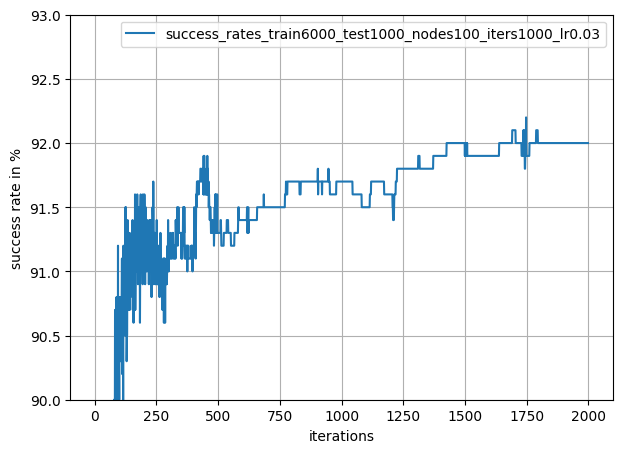

In [22]:
# here you can plot several training curves alongside each other 
# uncomment, delete, edit, copy-paste lines correspondingly
# edit the NAME of the results to be plotted AND edit the LABEL, such that the legend is correct
plt.figure(figsize = (7,5))
#plt.plot(success_rates['success_rates_train6000_test1000_nodes30_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes30_iters1000_lr0.03')
plt.plot(success_rates['success_rates_train6000_test1000_nodes800_iters2000_lr0p8'], label = 'success_rates_train6000_test1000_nodes100_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes300_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes300_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes784_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes784_iters1000_lr0.03')
#plt.plot(success_rates['success_rates_train6000_test1000_nodes1000_iters1000_lr0p03'], label = 'success_rates_train6000_test1000_nodes1000_iters1000_lr0.03')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('success rate in %')
plt.grid()
plt.ylim([90,93]) # uncomment line to restrict the y-range for more detailed view on the late training

In [114]:
# Exercises

# explore the hyperparameters
# - number of nodes
# - learning rate
# - size of traing data set
#
# keep size of test data set constant, e.g. 1000
# 
# a strong increase in number of iterations beyond 1000 is  
# recommended only AFTER exploring other prameters to some extent
